# Alexander Le's 2021 REU Harvard System Biology Internship
## Sponsored by:
<ul> 
<li>Harvard Medical School: Blavatnik Institute</li>
<li>National Science Foundation</li>
<li>Simons Foundation</li>
<li>Harvard QBio</li>
</ul>


### Principal Investigator: Dr. Cengiz Pehlevan
### Primary Mentor: Ugne Kilbaite

## Introduction

We do not know exactly how the nervous system controls motor behavior in health or disease. Many scientific studies designed to reveal the brain areas, circuits, and chemistry are first conducted in rats, before being conducted in humans. Currently, it is extraordinarily time-intensive to record, interpret, and analyze rat movements 24/7, making it difficult if not impossible to relate these behaviors to neural activity. Therefore I am trying to solve this problem using computational techniques. My current internship project in the Pehlevan Lab is to develop a method for modeling the skeleton using a video feed of animal behavior. There are two major barriers to achieving this goal: (1) we do not always know which 3D data point on the external body correlates to which internal joint; and (2) some data points may not be picked up by the cameras due to environmental noise. Thus, we developing a machine-learning algorithm to predict the name of a 3D data point as well as predict the 3D coordinate of missing points. This algorithm consists of 3 major components: a convolutional neural network (CNN) for initial prediction of points, a graph neural network (GNN) for temporal prediction of points, and a variational autoencoder (VAE) to predict the coordinates of missing points. The code in this notebook consists of the CNN used to predict existing points. Although there is existing software that can help determine the 3D points in space, the code is not optimized for rat behavior and does not account for missing points. Furthermore, we are unable to modify the code to fit different needs since it is proprietary. My research will develop an accessible tool that will enable the analysis of real-time rat behavior without time-intensive user input. We are in a good position to develop this program because we have access to large amounts of rat movement recordings and a robust computing system that can process this large data. As a consequence of our work, many labs will also be able to more powerfully and efficiently determine how mutations, neurological conditions, environmental exposures, or medical interventions affect rat movement and behavior, generating insights and strategies for improving human health.

# Code Introduction

The following code constructs a CNN that can predict the identity of a point in a given frame. The following notebook is divided into two major sections. The first section is to create a CNN to train and test a deep learning model using TensorFlow. The second section is to take temporal data and predict a cluster of points in time. At the end of the program, you can visualize a rat's movement in 3D space.  

In [1]:
'''Import necessary libraries and modulues for the program to run'''

import progressbar
import os
import h5py
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import mpl_toolkits.mplot3d.axes3d as p3
from statistics import median
from scipy.io import loadmat
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from matplotlib.animation import FuncAnimation
from scipy.spatial.distance import cdist

In [2]:
'''Initialize global variables'''

# list of joint names
joint_name = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM', 'SpineL', 
            'Offset1', 'Offset2', 'HipL', 'HipR', 'ElbowL', 'ArmL', 
            'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 
            'KneeL', 'ShinL', 'ShinR']

# list of joint connections
joints_idx = [[1, 2], [2, 3], [1, 3], [2, 4], [1, 4], [3, 4], [4, 5], 
            [5, 6], [4, 7], [7, 8], [5, 8], [5, 7], [6, 8], [6, 9], 
            [6, 10], [11, 12], [4, 13], [4, 14], [11, 13], [12, 13], 
            [14, 15], [14, 16], [15, 16], [9, 18], [10, 17], [18, 19], 
            [17, 20]]

In [3]:
'''Create folders to save machine learning model'''

def createSaveFolder():
    '''
    input: None
    output: Directory where the model is saved in
    '''
    
    if not os.path.isdir('datasets'):
        os.mkdir('datasets')
    save_folder = 'datasets/skeleton/'
    if not os.path.isdir(save_folder):
        os.mkdir(save_folder)
    return save_folder

In [4]:
'''Normalizes a matrix by dividing by the largest values in the array'''

def normalize(matrix):
    '''
    Input: 2D array of features derived from the raw 3D points
    Output: Normalized 2D array where the max number is 1
    '''
    
    max_numb = max(matrix[~np.isnan(matrix)])
    norm = matrix/max_numb
    return np.array(norm)

In [5]:
'''Determine the distance from a single point to every other point in a frame''' 

def getAllDistances(matFile, numb):
    '''
    Input:
        matFile: 2D array of raw coordinate data, [x coordinates, y coordinates, z coordinates]
        numb: Int of the frame we want to look at
    Output: 
        angle: 2D array of raw distances
        norm: 2D array of normalized distances
        max_angle: int of max distances
    '''
    
    mat = matFile[numb]
    mat = mat.T
    dist = cdist(mat, mat, 'euclidean')
    norm = normalize(dist)
    max_dist = max(dist.flatten())
    return dist, norm, max_dist

In [6]:
'''Determine the absolute height difference from a single point to every other point in a frame''' 

def getAllHeights(matFile, numb):
    '''
    Input:
        matFile: 2D array of raw coordinate data, [x coordinates, y coordinates, z coordinates]
        numb: Int of the frame we want to look at
    Output: 
        angle: 2D array of raw heights
        norm: 2D array of normalized heights
        max_angle: int of max height
    '''

    mat = matFile[numb]
    # get z coordinates
    z = mat[2] 
    num_pts = int(matFile.shape[2])
    height_diff = []

    for i in range(num_pts):
        for j in range(num_pts):
            if np.nan in [z[i], z[j]]:
                height_diff.append(np.nan)
            else:
                height_diff.append(np.abs(z[i]-z[j]))

    height = np.array(height_diff).reshape(num_pts, num_pts)
    norm = normalize(height)
    max_height = max(height.flatten())
    return height, norm, max_height

In [7]:
'''Determine the angle from a single point to every other point in a frame'''

def getAllAngles(matFile, numb):
    '''
    Input:
        matFile: 2D array of raw coordinate data, [x coordinates, y coordinates, z coordinates]
        numb: Int of the frame we want to look at
    Output: 
        angle: 2D array of raw angles
        norm: 2D array of normalized angles
        max_angle: int of max angle
    '''

    mat = matFile[numb]
    mat = mat.T
    angle = cdist(mat, mat, 'cosine')
    norm = normalize(angle)
    max_angle = max(angle.flatten())
    return angle, norm, max_angle

In [8]:
'''Method that obtains all the metrics from the raw 3D data and creates CNN inputs for the ML model to train/test'''

def pureData(data, numb): 
    '''
    Input:
        data: Raw 3D array of raw coordinate data, total frames X [x coordinates, y coordinates, z coordinates]
        numb: Int of the frames we want to look at
    Output: 
        pureData: 2D array of CNN inputs for the ML model
    '''

    cnn_inputs = []
    max_dist_list = []
    max_height_list = []
    max_angle_list = []

    bar = progressbar.ProgressBar()
    for i in bar(range(numb)):
        # Calculate Metrics from methods created above
        dist, norm_dist, max_dist = getAllDistances(data, i) 
        height, norm_height, max_height = getAllHeights(data, i)
        angle, norm_angle, max_angle = getAllAngles(data, i)

        # Run through all the raw inputs and create a metric for every single point 
        # consisting of distance, height and angle measurements to every other point
        for j in range(0, data.shape[2]):
            temp = np.array([dist[j], height[j], angle[j]])
            first = temp[:,0:3]
            second = temp[:,3:20]
            # sort the data based on the distance meteric 
            first = first [ :, first[0].argsort()]
            second = second [ :, second[0].argsort()]
            # Concatenate the three head points with the 10 closest points
            output = np.concatenate((first, second), axis =1)
            cnn_inputs.append(output)

            # Find the largest distance, height and angle from the 13 input points
            big = output[:,:13]
            where_are_NaNs = np.isnan(big)
            big[where_are_NaNs] = 0
            max_dist_list.append(np.max(big[0]))
            max_height_list.append(np.max(big[1]))
            max_angle_list.append(np.max(big[2]))

    # get the median max distance, height and angle from all frames
    avg_max_dist = median(max_dist_list)
    avg_max_height = median(max_height_list)
    avg_max_angle = median(max_angle_list)
    avg_max = [avg_max_dist, avg_max_height, avg_max_angle]

    # normalize all the meterics by the median max distance, height and angle
    cnn_inputs = np.array(cnn_inputs)[:,:,:13]
    final = []
    for i in range(len(cnn_inputs)):
        for j in range(3):
            final.append(cnn_inputs[i][j]/avg_max[j])
    
    # reshapes the inputs to a 2D array 
    cnn_inputs = np.array(final).reshape((cnn_inputs.shape[0], 39))

    # remove all the nan values and set them to 0
    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0
    return cnn_inputs


In [9]:
'''Method that can be manipulated to act as a switch to test diffent ways to obtain metrics and improve accuracy'''

def getData(data, numb):
    '''
    Input:
        data: Raw 3D array of raw coordinate data, total frames X [x coordinates, y coordinates, z coordinates]
        numb: Int of the frames we want to look at
    Output: 
        pureData: 2D array of CNN inputs for the ML model
    '''
    return pureData(data, numb)

In [10]:
'''Method that creates the train data/labels and test data/labels'''

def trainTest(train_data, test_data, train_labels, test_labels, numb_train, numb_test):
    '''
    Input:
        train_data: 3D array of raw coordinate data, total frames X [x coordinates, y coordinates, z coordinates]
        test_data: 3D array of raw coordinate data, total frames X [x coordinates, y coordinates, z coordinates]
        train_labels: 2D array of raw labels, frames X [label int position]
        test_labels: 2D array of raw labels, frames X [label int position]
        numb_train: Number of training data points
        numb_test: Number of testing data points
    Output: 
        train_data_new: 2D array of processed data, total points X [calculated meterics]
        test_data_new: 2D array of processed data, total points X [calculated meterics]
        train_labels_new: array of processed labels, total points X [labels]
        test_labels_new: array of processed labels, total points X [labels]
    '''

    # create training data/labels
    pre_train_data = train_data
    pre_train_labels = train_labels
    if numb_train != len(train_data):
        index_train = np.linspace(0, len(train_labels), num = numb_train, endpoint=False).astype(int)
        pre_train_data = train_data[index_train]
        pre_train_labels = train_labels[index_train]

    # create testing data/labels
    index_test = np.linspace(0, len(test_labels), num = numb_test, endpoint=False).astype(int)
    pre_test_data = test_data[index_test]
    pre_test_labels = test_labels[index_test]

    # Get meteric data for every point
    print("Getting messurements")
    train_data = getData(pre_train_data, numb_train)
    test_data = getData(pre_test_data, numb_test)

    # Flatten the labels to fit dimentions of data
    train_labels = pre_train_labels.flatten()[0:(numb_train*20)]-1
    test_labels = pre_test_labels.flatten()[0:(numb_test*20)]-1

    # Get index where the data is all 0
    nans_train = np.sort(np.where(~train_data.any(axis=1))[0])[::-1]
    nans_test = np.sort(np.where(~test_data.any(axis=1))[0])[::-1]
    # Turn data into lists
    train_data_new = list(train_data)
    test_data_new = list(test_data)
    train_labels_new = list(train_labels)
    test_labels_new = list(test_labels)

    # Remove all the nan values to show acutal accuracy
    print("Removing nans")
    bar = progressbar.ProgressBar()
    for i in bar(nans_train):
        train_data_new.pop(i)
        train_labels_new.pop(i)
    bar = progressbar.ProgressBar()
    for i in bar(nans_test):
        test_data_new.pop(i)
        test_labels_new.pop(i)

    # Turn data back into np arrays
    train_data_new = np.array(train_data_new)
    train_labels_new = np.array(train_labels_new)
    test_data_new = np.array(test_data_new)
    test_labels_new = np.array(test_labels_new)
    return train_data_new, test_data_new, train_labels_new, test_labels_new

## Creating machine learning input data

To create the machine learning input data, we have to first load the raw data and process them by running it through the funcitons initialized above

In [11]:
'''This method loads the raw data and saves/loads data and labels for the machine learning model'''

def ML_Data(create_data, save_files, save_folder):
    '''
    Input:
        create_data: Boolean where True if we want to create new data 
        save_files: Boolean where True if we want to save files
        save_folder: folder to save the files in 
    Output:
        train_data_new = 2D array of processed data, total points X [calculated meterics]
        test_data_new = 2D array of processed data, total points X [calculated meterics]
        train_labels_new = array of processed labels, total points X [labels]
        test_labels_new = array of processed labels, total points X [labels]
        numb_test = int of points being tested
    '''

    # create variables 
    train_data_new = None
    test_data_new = None
    train_labels_new = None
    test_labels_new = None

    if create_data:
        # load data
        train_file = loadmat('mat_files/bigSet1.mat')
        test_file = loadmat('mat_files/bigSet2.mat')
        train_data = train_file['bigSet1']
        test_data = test_file['bigSet2']
        train_labels = train_file['labels1']
        test_labels = test_file['labels2']

        # set numb of data used
        numb_train = len(train_data)
        numb_test = 10000

        # get data from trainTest method
        train_data_new, test_data_new, train_labels_new, test_labels_new = trainTest(train_data, test_data, train_labels, test_labels, numb_train, numb_test)
        
        # save the data as .npy files
        if (save_files): 
            print("Saving to:", save_folder)
            np.save(save_folder + 'train_data.npy', np.asarray(train_data_new))
            np.save(save_folder + 'train_labels.npy', np.asarray(train_labels_new))
            np.save(save_folder + 'test_data.npy', np.asarray(test_data_new))
            np.save(save_folder + 'test_labels.npy', np.asarray(test_labels_new))
        return train_data_new, test_data_new, train_labels_new, test_labels_new, numb_test
    else:
        # load saved files
        try:
            train_data_new = np.load(save_folder + 'train_data.npy')
            train_labels_new = np.load(save_folder + 'train_labels.npy')
            test_data_new = np.load(save_folder + 'test_data.npy')
            test_labels_new = np.load(save_folder + 'test_labels.npy')
            numb_test = len(test_labels_new)
            return train_data_new, test_data_new, train_labels_new, test_labels_new, numb_test
        except:
            print("There are no files to be opened")

In [12]:
'''Creates the ML training model to predict rat joints'''

def ml_training(train_data, train_labels, test_data, test_labels, save, save_folder):
    '''
    Input: 
        train_data: 2D array of processed data, total points X [calculated meterics]
        train_labels: array of processed labels, total points X [labels]
        test_data: 2D array of processed data, total points X [calculated meterics]
        test_labels: array of processed labels, total points X [labels]
        save: Boolean where True if we want to save ML model
    Output: 
        ml_model: Sequential ML model
    '''

    # Reshape and format data
    ml_train_data = train_data.reshape(train_data.shape[0], 39)
    ml_test_data = test_data.reshape(test_data.shape[0], 39)
    ml_train_data = ml_train_data.astype('float32')
    ml_test_data = ml_test_data.astype('float32')
    
    # create ML model
    ml_model = createModel()

    # Train model
    if save:
        ml_folder = os.path.join(save_folder, "training")
        if not os.path.isdir(ml_folder):
            os.mkdir(ml_folder)
        checkpoint_path = ml_folder + "/cp.ckpt"
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

        ml_model.fit(x=ml_train_data,y=train_labels, verbose='auto', batch_size=100, epochs=5, validation_data=(ml_test_data, test_labels), callbacks=[cp_callback])
    else: 
        ml_model.fit(x=ml_train_data,y=train_labels, verbose='auto', batch_size=100, epochs=5, validation_data=(ml_test_data, test_labels))
    
    # Print loss and accuracy 
    loss, acc = ml_model.evaluate(ml_test_data, test_labels, verbose=1)
    print("Loss:", loss)
    print("Accuracy:", acc*100)
    return ml_model

In [13]:
'''Creates the model for the CNN'''

def createModel():
    '''
    Input: None
    Ouptut: 
        model: Sequential ML model
    '''

    model = Sequential()
    model.add(Dense(640, activation= LeakyReLU()))
    model.add(Dense(640, activation= LeakyReLU()))
    model.add(Dense(320, activation= LeakyReLU()))
    model.add(Dense(80, activation= LeakyReLU()))
    model.add(Dense(len(joint_name), activation = "softmax"))
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
'''If we already trained a model, load the pretrained model to use'''

def getStoredModel():
    '''
    Input: None
    Output:  
        skeleton_model: Sequential ML model 
    '''

    try:
        # Obtain file with saved ML model
        checkpoint_path = save_folder + "training/cp.ckpt"
        skeleton_model = createModel()
        skeleton_model.load_weights(checkpoint_path).expect_partial()

        # Evaluate the model
        loss, acc = skeleton_model.evaluate(test_data_new, test_labels_new)
        print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
        return skeleton_model
    except:
        print("There is no stored ML file")
        return None

In [15]:
'''Create confusion matrix of ML model'''

def dispConfMat(skeleton_model):
    '''
    Input:
        skeleton_model: Sequential ML model 
    Output: None
    '''

    # get confusion matrix
    test_pred = np.argmax(skeleton_model.predict(test_data_new), axis=-1)
    con_mat = tf.math.confusion_matrix(labels=test_labels_new, predictions=test_pred).numpy()
    row_sums = con_mat.sum(axis=1)
    new_matrix = con_mat / row_sums[:, np.newaxis]

    # plot confusion matrix and save it as tiff
    fig, ax = plt.subplots()
    ax.set_title("Confusion Matrix")
    ax.set_xticks((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19))
    ax.set_xticklabels(joint_name, rotation=90)
    ax.set_yticks((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19))
    ax.set_yticklabels(joint_name)
    ax.xaxis.tick_top()
    temp = ax.imshow(new_matrix,interpolation='nearest', aspect=1)
    plt.colorbar(temp, ax=ax)
    plt.tight_layout()
    fig.savefig("cm.tiff")

In [16]:
'''Trains or obtains pre-trained ML model'''

def get_model(train_data_new, train_labels_new, test_data_new, test_labels_new, save_folder, train):
    '''
    Input: 
        train_data_new = 2D array of processed data, total points X [calculated meterics]
        train_labels_new = array of processed labels, total points X [labels]
        test_data_new = 2D array of processed data, total points X [calculated meterics]
        test_labels_new = array of processed labels, total points X [labels] 
        save_folder: folder to save ML model
        train: Boolean where True if we want to train or load ML model 
    Output:
    '''

    skeleton_model = None
    if train:
        skeleton_model = ml_training(train_data_new, train_labels_new, test_data_new, test_labels_new, True, save_folder)
    else:
        skeleton_model = getStoredModel()
    
    # show confusion matrix 
    dispConfMat(skeleton_model)
    return skeleton_model

In [17]:
'''Tests individual points and tells you if the CNN worked'''

def handTest(image_index, test_data, label, model, maxNumb):
    '''
    Input:
        image_index: int of point you want to predict
        test_data: 2D array 
        label:
        model:
        maxNumb:
    Output:
    '''
    if image_index <= maxNumb:
        predict(test_data, image_index, label, model)
    else:
        print("ERROR: Your predict_index must be below", maxNumb)

In [18]:
# Showing individual predictions
def predict(data, image_index, label, model):
    img = data[image_index]
    length_flat = len(img)
    length_img = int(length_flat/3)
    img = np.array(img).reshape(3,length_img)
    plt.imshow(img)
    plt.title("Meterics for head points and 10 closest points")
    plt.xlabel("Points in frame")
    plt.ylabel("Height, Angle, Distance ")
    plt.tight_layout()
    plt.show()
    
    pred = model.predict(img.reshape(1, length_flat))
    predict = pred.argmax()
    actual = label[image_index]

    print("Actual:", actual)
    print("Predicted:", predict)
    
    if predict == actual:
        print("YAY ✿(ᵔ‿ᵔ)")
    else:
        print("Wrong (◕︵◕)")

In [19]:
# create folder to save data
save_folder = createSaveFolder()

# Get data for ML training 
create_data = False
save_files = True
train_data_new, test_data_new, train_labels_new, test_labels_new, numb_test = ML_Data(create_data, save_files, save_folder)

5691/5691 [==============================] - 35s 6ms/step - loss: 0.6657 - accuracy: 0.8129
Restored model, accuracy: 81.29%


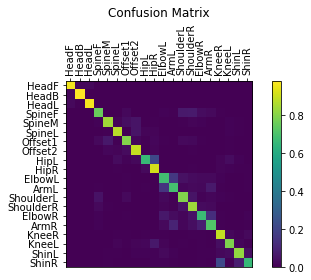

In [20]:
skeleton_model = get_model(train_data_new, train_labels_new, test_data_new, test_labels_new, save_folder, False)

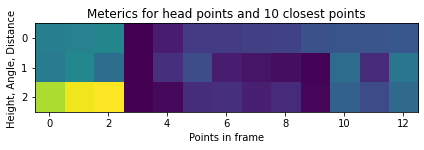

Actual: 18
Predicted: 16
Wrong (◕︵◕)


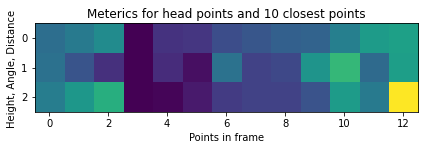

Actual: 12
Predicted: 12
YAY ✿(ᵔ‿ᵔ)


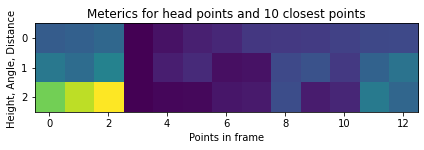

Actual: 19
Predicted: 19
YAY ✿(ᵔ‿ᵔ)


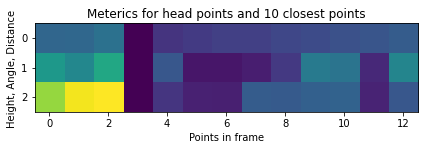

Actual: 14
Predicted: 14
YAY ✿(ᵔ‿ᵔ)


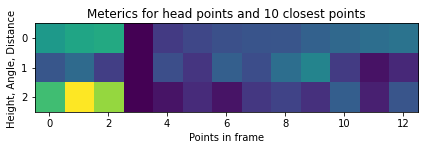

Actual: 5
Predicted: 5
YAY ✿(ᵔ‿ᵔ)


In [21]:
for i in range(420,425):
    handTest(i, test_data_new, test_labels_new, skeleton_model, numb_test)

In [22]:
'''Loads in temporal data from mat or h5py files and formats in a readable context'''

def getTemporalData(mat_file):
    '''
    Input:
        mat_file: Boolean where True opens a mat file and False opens a h5py file
    Output:
        new_temp_data: 2D array of temporal data
        new_temp_labels: 2D array of temporal labels
        num_fms: int number of frames
        num_pts: int number of pts
    '''
    
    copy_data = None 
    copy_labels = None

    if mat_file:
        # loads a temporal mat file 
        temporal_file = loadmat('mat_files/bigSet3.mat')
        temp_data = temporal_file['bigSet3']
        temp_labels = temporal_file['labels3']
        copy_data = temp_data.copy()
        copy_labels = temp_labels.copy()
        copy_data = np.transpose(copy_data,(2,1,0))
        copy_labels = copy_labels.T
    else: 
        # loads a temporal h5py file 
        temporal_file = h5py.File('mat_files/JDM25baseline_Ext4_timematched_controltsne_analysis_struct_mocapdata.mat', 'r') 
        temp_data = temporal_file['alteredM'][:]
        temp_labels = temporal_file['labelsM'][:]
        temporal_file.close()
        copy_data = temp_data.copy()
        copy_labels = temp_labels.copy()
        
    new_temp_data = copy_data[:,:,:10000]
    num_fms =  new_temp_data.shape[2]
    num_pts = len(new_temp_data)
    new_temp_labels = copy_labels[:,:num_fms]
    
    return new_temp_data, new_temp_labels, num_fms, num_pts

In [23]:
def processTempData(new_temp_data, new_temp_labels):
    time_pts = []
    bar = progressbar.ProgressBar()
    for i in bar(range(new_temp_labels.shape[1])):
        label = np.array(new_temp_labels[:,i])
        data = new_temp_data[:,:,i]
        stack = np.column_stack((data, label))
        stack = np.array(sorted(stack,key=lambda x: x[3]))
        time_pts.append(stack[:,:3])
        
    time_pts = np.array(time_pts).reshape(num_fms, 3*num_pts).T
    plt.imshow(time_pts, interpolation='nearest', aspect="auto")
    plt.title("Full segments")
    plt.xlabel("Frames")
    plt.ylabel("XYZ points")
    plt.show()
    return time_pts

100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


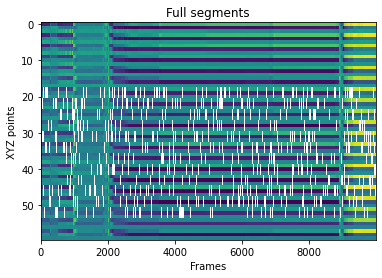

In [24]:
mat_file = True
new_temp_data, new_temp_labels, num_fms, num_pts = getTemporalData(mat_file)
test_pts = processTempData(new_temp_data, new_temp_labels)

In [25]:
def removeChunks(test_pts):
    time_pts = test_pts.copy()
    for i in range(3,num_pts):
        times = random.randint(2,4)
        for j in range(times):
            length_gap = random.randint(600, 2000)
            start_gap = random.randint(0,num_fms-1)
            end_gap = start_gap + length_gap
            time_pts[i*3][start_gap:end_gap] = np.nan
            time_pts[i*3+1][start_gap:end_gap] = np.nan
            time_pts[i*3+2][start_gap:end_gap] = np.nan
    plt.imshow(time_pts, interpolation='nearest', aspect="auto")
    plt.title("Full segments")
    plt.xlabel("Time (frames)")
    plt.ylabel("XYZ points")
    plt.show()
    return time_pts

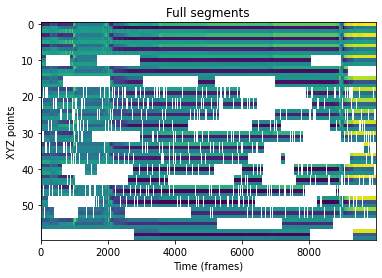

In [26]:
time_pts = removeChunks(test_pts)

In [27]:
def processPoints(time_pts):
    input_pts = time_pts.reshape(num_pts, 3, num_fms).T
    processed_time = getData(input_pts, len(input_pts))
    process_pts = processed_time.reshape(num_fms, num_pts, 39)
    processed = np.transpose(process_pts,(1, 0, 2))
    return processed

In [28]:
processed = processPoints(time_pts)

 42% (4244 of 10000) |########           | Elapsed Time: 0:00:19 ETA:   0:00:19

KeyboardInterrupt: 

In [ ]:
def getChunks(num_pts, num_fms, time_pts):
    chunks = []
    temp = np.ones((num_pts,num_fms))
    bar = progressbar.ProgressBar()
    # run through all the registered points (0,22)
    for i in bar(range(num_pts)):
        # get every third row
        row = i*3
        row_list = []
        temp_list = []

        # run through length of each row (0,3000)
        for j in range(num_fms): 
            # not a nan, add index to list
            if not np.isnan(time_pts[row][j]):
                temp_list.append(j)
                temp[i][j] = temp[i][j]*2
            # if element is a nan and the current list is not empty
            elif len(temp_list) > 0:
                # add list to output and clear the list
                row_list.append([temp_list[0], temp_list[-1]])
                temp_list = []
        # edge case, add to output if the list still contains values
        if len(temp_list) > 0:
            row_list.append([temp_list[0], temp_list[-1]])
        chunks.append(row_list)

    chunks = np.array(chunks, dtype=list)
    for i in range(len(chunks)):
        print("Point: "+str(i) +", Segments: " + str(len(chunks[i])))
    
    return chunks

In [ ]:
chunks = getChunks(num_pts, num_fms, time_pts)

100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Point: 0, Segments: 1
Point: 1, Segments: 1
Point: 2, Segments: 1
Point: 3, Segments: 3
Point: 4, Segments: 3
Point: 5, Segments: 2
Point: 6, Segments: 904
Point: 7, Segments: 1091
Point: 8, Segments: 1056
Point: 9, Segments: 836
Point: 10, Segments: 958
Point: 11, Segments: 1063
Point: 12, Segments: 776
Point: 13, Segments: 740
Point: 14, Segments: 745
Point: 15, Segments: 974
Point: 16, Segments: 853
Point: 17, Segments: 1030
Point: 18, Segments: 2
Point: 19, Segments: 3


In [ ]:
def getTemporalData(chunks, skeleton_model):
    temporal_data = []
    # loop through all the points (0,22)
    for i in range(len(chunks)):
        prediction = []
        confidence = []
        data = chunks[i] # list of chunks in a given row
        model_pred = skeleton_model.predict(processed[i])
        print("Point: "+ str(i) + ", Segments: " + str(len(data)))
        for j in range(len(data)):
            seg_range = data[j] 
            lower = seg_range[0]
            upper = seg_range[1]+1
            seg_len = upper - lower
            seg = model_pred[lower:upper]
            
            # get the predictions per frame
            pred_frame = seg.argmax(axis=-1)
            # adding up all the confident scores together
            conf_sum = np.sum(seg, axis=0)/seg_len
            # get the prediction with highest confident score
            pred = conf_sum.argmax()
            # get the highest confident score 
            conf = conf_sum.max()
            # count how many times the prediction apppears per chunk 
            pred_count = np.sum(pred == pred_frame)
            # get the percent of how many times it appears 
            pred_mode = pred_count/seg_len
            # get the list of predictions in decending order 
            rank_pred = np.argsort(conf_sum.argsort())

            # print(i, ": (", j+1, "/", len(data), "):", pred ,"[", lower, ",", upper, "], (", pred_count, "/", seg_len, ") =", pred_mode, ",", conf)
            add_data = [i, rank_pred, seg_range, pred_count, seg_len, pred_mode, conf, conf_sum]
            prediction.append(add_data)
        temporal_data.append(prediction)
    return temporal_data

In [ ]:
temporal_data = getTemporalData(chunks, skeleton_model)

Point: 0, Segments: 1
Point: 1, Segments: 1
Point: 2, Segments: 1
Point: 3, Segments: 3
Point: 4, Segments: 3
Point: 5, Segments: 2
Point: 6, Segments: 904
Point: 7, Segments: 1091
Point: 8, Segments: 1056
Point: 9, Segments: 836
Point: 10, Segments: 958
Point: 11, Segments: 1063
Point: 12, Segments: 776
Point: 13, Segments: 740
Point: 14, Segments: 745
Point: 15, Segments: 974
Point: 16, Segments: 853
Point: 17, Segments: 1030
Point: 18, Segments: 2
Point: 19, Segments: 3


In [ ]:
def checkTemporal(temporal_data, num_pts, num_fms):
    temp_new = np.ones((num_pts,num_fms))
    for i in range(len(temporal_data)):
        for j in range(len(temporal_data[i])):
            start = temporal_data[i][j][2][0]
            end = temporal_data[i][j][2][1] + 1
            for k in range(start, end):
                temp_new[i][k] +=1
    plt.imshow(temp_new, interpolation='nearest', aspect="auto", cmap = "Set3")
    plt.title("Full segments")
    plt.xlabel("Time (frames)")
    plt.ylabel("XYZ points")
    plt.show()

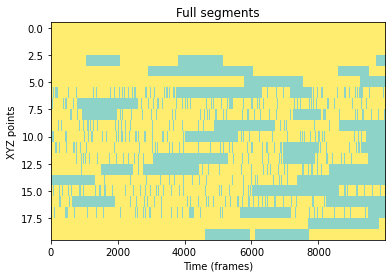

In [ ]:
checkTemporal(temporal_data, num_pts, num_fms)

In [ ]:
def getSegmentation(temporal_data, num_pts):
    temp_copy = temporal_data.copy()
    temp_data = np.array(temp_copy, dtype=object)
    segment_data = []

    for i in range(20):
        segment_data.append([])    

    # putting the preditions into buckets
    for i in range(num_pts):
        index = temp_data[i]
        for j in range(len(index)):
            segment_data[index[j][1].argmax()].append(index[j])
    for i in range(len(segment_data)):
        print("Joint:",i, "Segment:", len(segment_data[i]))
    return segment_data

In [ ]:
segment_data = getSegmentation(temporal_data, num_pts)

Joint: 0 Segment: 0
Joint: 1 Segment: 63
Joint: 2 Segment: 70
Joint: 3 Segment: 84
Joint: 4 Segment: 444
Joint: 5 Segment: 10
Joint: 6 Segment: 508
Joint: 7 Segment: 465
Joint: 8 Segment: 854
Joint: 9 Segment: 902
Joint: 10 Segment: 453
Joint: 11 Segment: 1882
Joint: 12 Segment: 896
Joint: 13 Segment: 760
Joint: 14 Segment: 100
Joint: 15 Segment: 1106
Joint: 16 Segment: 1207
Joint: 17 Segment: 570
Joint: 18 Segment: 256
Joint: 19 Segment: 412


In [ ]:
def squish(chunk_data):
    unprocessed_pts = []
    processed_pts = []
    # squish all the data points
    for i in range(20): 
        numb_index = []
        unprocessed = []
        bounds = None
        current = chunk_data[i]
        cert = chunk_data[i]
        sorted_current = sorted(current,key=lambda x: x[4])
        
        for j in reversed(range(len(sorted_current))):
            input_index = sorted_current[j]
            current_bounds = np.arange(input_index[2][0], input_index[2][1]+1).tolist()

            if len(numb_index) == 0:
                numb_index.append(input_index)
                bounds = current_bounds
            else:
                same = list(set(current_bounds) & set(bounds)) # gets overlapping elements 
                # no overlapp between the two lists
                if len(same) == 0:
                    numb_index.append(input_index)
                    bounds += current_bounds
                else: #if there is overlap between the two lists
                    if current_bounds[0] in bounds or current_bounds[-1] in bounds:
                        unprocessed.append(input_index)
                        pass
                    elif current_bounds[0] in bounds:
                        print("Lower bound inside current bounds")
                        pass
                    elif current_bounds[-1] in bounds:
                        print("Upper bound inside current bounds")
                        pass
            bounds = sorted(bounds)
        processed_pts.append(numb_index)
        unprocessed_pts.append(unprocessed)

    processed_pts = np.array(processed_pts, dtype = object)
    unprocessed_pts = np.array(unprocessed_pts, dtype = object)
    return processed_pts, unprocessed_pts
 

In [ ]:
processed_pts, unprocessed_pts = squish(segment_data)

In [ ]:
def predictedSegments(time_pts, processed_pts, num_fms):
    final_points = []
    point_coord = np.ones((60,num_fms))*np.nan
    error = False
    for i in range(len(processed_pts)):
        index = [i*3, i*3+1, i*3+2]
        coord = [[],[],[]]

        for j in range(len(processed_pts[i])):
            seg_range = processed_pts[i][j]
            org_index = seg_range[0]
            start = seg_range[2][0]
            end = seg_range[2][1]
            index_xyz = [org_index*3, org_index*3+1, org_index*3+2]

            for k in range(start, end):
                point_coord[index[0]][k] = time_pts[index_xyz[0]][k]
                point_coord[index[1]][k] = time_pts[index_xyz[1]][k]
                point_coord[index[2]][k] = time_pts[index_xyz[2]][k]
                if np.isnan(time_pts[index_xyz[0]][k]):
                    error = True
                    # print("big error", seg_range)
    if error:
        print("BIG MISTAKE OCCURED")
    
    # headpoints
    headpts = time_pts[:3,:]
    bodypt = point_coord[3:,:]
    point_coord = np.concatenate((headpts,bodypt))

    return point_coord

In [ ]:
point_coord = predictedSegments(time_pts, processed_pts, num_fms)

In [ ]:
def orginal_VS_processed(time_pts, point_coord):
    plt.imshow(time_pts, interpolation='nearest', aspect="auto")
    plt.title("Original Full segments")
    plt.xlabel("Frames")
    plt.ylabel("XYZ points")
    plt.show()

    plt.imshow(point_coord, interpolation='nearest', aspect="auto")
    plt.title("Predicted Full segments")
    plt.xlabel("Time (frames)")
    plt.ylabel("XYZ points")
    plt.show()


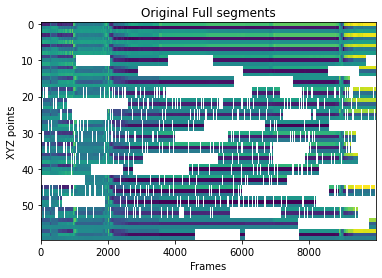

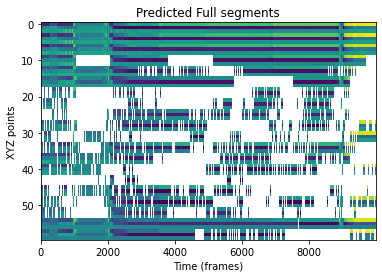

In [ ]:
orginal_VS_processed(time_pts, point_coord)

In [ ]:
figure = point_coord.copy()#[:,::5]
connections = [[0,1,2,0], [2,3,4,5], [3,6,7,5], [10, 11, 12, 3, 13, 14, 15], [18,17,8,5,9,16,19]]

fig = plt.figure()
ax = p3.Axes3D(fig)
fig.add_axes(ax)
ax.set_title("Predicted Skeleton")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")

def animfunc(t):
    ax.clear()
    
    lines = []
    frame = t
    for conn in connections:
        x = [3*i for i in conn]
        y = [i+1 for i in x]
        z = [i+2 for i in x]
        lines.append(ax.scatter(figure[x, frame], figure[y,frame],  figure[z, frame], color='b', s =10))
        lines.append(ax.plot(figure[x, frame], figure[y,frame],  figure[z, frame], linewidth=3))
    return lines,
        
anim = FuncAnimation(fig, animfunc, frames=figure.shape[1], interval=10, repeat=False)

Error: Session cannot generate requests

In [ ]:
%matplotlib inline